In [2]:
import pandas as pd #
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import math #
from sklearn import preprocessing #

import warnings
warnings.filterwarnings('ignore')

#sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc, precision_score, accuracy_score,recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV #
from sklearn.model_selection import train_test_split #
from sklearn.model_selection import cross_val_predict 
from sklearn.model_selection import cross_val_score #
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold #
from sklearn.model_selection import cross_validate #

from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OneHotEncoder #

from sklearn.ensemble import RandomForestClassifier #
import xgboost
from xgboost import XGBClassifier
from scipy import interp

import shap
from shap import TreeExplainer
from category_encoders import *
import pickle
from pickle import load
from time import sleep
from tqdm.notebook import tqdm
import joblib
from joblib import load as jload
from collections import Counter
import seaborn as sns
import time
# some notebook settings
from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import display, HTML
InteractiveShell.ast_node_interactivity = "all"
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(precision=4, suppress=True, linewidth=110)

pd.set_option('display.max_columns', 1000)  # or 1000
pd.set_option('display.max_rows', 2000)  # or 1000
pd.set_option('display.max_colwidth', None)
sns.set_theme()

# Closer to reality

After discussing again with inspectors, it appears that their team is not inspecting classes 7 (radioactive) and 1(explosives) - which is confirmed by the feature importance of the vanilla model. We thus made the decision to discard those features. 

As an additional experiment i was curious how the performance varies with the number of features included. We will not take features out, as we have to be careful how to do that because there is a **trade-off** between the amount of insights inspectors get and the performance of the model: if you leave all possibly relevant columns in, the performance might drop but the inspectors might get more insights.

In [11]:
#read dictonary
pkl_file = open('feature_optim_dict.pickle', 'rb')
my_dict = pickle.load(pkl_file)

dict_keys(['features_nr', 'features', 'feature_importance', 'best_params', 'score', 'model', 'time_to_fit', 'feature_rank'])

Text(0.5, 0, 'Nr. of features')

Text(0, 0.5, 'Precision')

([<matplotlib.axis.XTick at 0x7f5684334e80>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

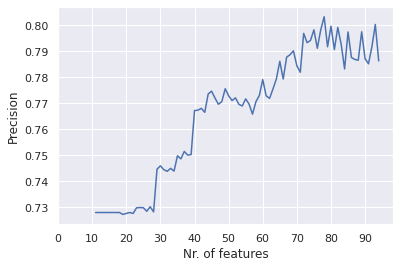

In [12]:
#looking first at performance across the combinations of features

my_dict.keys()

scores = my_dict['score']
features_nr = my_dict['features_nr']

plt.plot(features_nr,scores)
plt.xlabel('Nr. of features')
plt.ylabel('Precision')
xticks = [x*10 for x in list(range(0,10))]
plt.xticks(xticks)
plt.show()

It looks like the best performance is with ~79 features.

## Deleting columns rel to class 1 and 7. Run the model but keep 10% as OOS

In [13]:
df = pd.read_csv('clean_holmes_2019.csv')
df.head()


,class_1_1_explosives_mass,class_1_2_explosives_projection,class_1_3_explosives_fire,class_1_4_explosives_low_risk,class_1_5_explosives_mass_very_insensitive,class_1_6_explosives_very_insensitive,class_2_1_flammable_gases,class_2_2_non_flammable_non_toxic_gases,class_2_3_toxic_gases,class_3_flammable_liquids,class_4_1_flammable_solids,class_4_2_spontaneous_combustion,class_4_3_flammable_gases_in_contact_water,class_5_1_oxidizing_substances,class_5_2_organic_peroxides,class_6_1_toxic_substances,class_6_2_infectious_substances,class_7_radioactive_material,class_8_corrosives,class_9_miscellaneous_dangerous_goods,PG_I_high_danger,PG_II_medium_danger,PG_III_low_danger,Quantity_total,Nr_dif_UNNRs,Packaging_DRUM_yn,Packaging_JERRYCAN_yn,Packaging_BOX_yn,Packaging_BAG_yn,Packaging_COMPOSITE_yn,Packaging_UNPACKED_yn,Packaging_IBC_yn,Packaging_LP_yn,Packaging_Bulk_container_yn,Packaging_PR_yn,METAL_packaging_yn,WOODEN_packaging_yn,PLASTIC_packaging_yn,OTHER_packing_material_yn,Prisma_object_type_corrected_Container,Prisma_object_type_corrected_IMO or UN transport tank,Prisma_in_outgoing_corrected_Incoming,Prisma_in_outgoing_corrected_Outgoing or Transshipment,Prisma_terminal_corrected_APM Terminals Maasvlakte II,Prisma_terminal_corrected_APM Terminals Rotterdam,Prisma_terminal_corrected_ECT Delta Terminal,Prisma_terminal_corrected_Euromax Terminal,Prisma_terminal_corrected_Other terminal,Prisma_terminal_corrected_Rotterdam World Gate Terminal (RWG),Prisma_region_origin_incoming_corrected_Africa,Prisma_region_origin_incoming_corrected_China,Prisma_region_origin_incoming_corrected_India,Prisma_region_origin_incoming_corrected_Latin_America,Prisma_region_origin_incoming_corrected_Middle_East,Prisma_region_origin_incoming_corrected_Rest_of_the_world,Prisma_region_origin_incoming_corrected_South_East_Asia,Prisma_region_destination_incoming_corrected_Europe,Prisma_region_destination_incoming_corrected_Netherlands,Prisma_region_destination_incoming_corrected_Rest_of_the_world,Prisma_cargo_agent_corrected_8 - CMA CGM (Holland) B.V.,Prisma_cargo_agent_corrected_20 - Hapag-Lloyd Rotterdam,Prisma_cargo_agent_corrected_22 - Hyundai Merchant Marine,Prisma_cargo_agent_corrected_24 - Maersk Line,Prisma_cargo_agent_corrected_25 - Mediterranean Shipping Company,Prisma_cargo_agent_corrected_27 - Mueller Liner Agency,Prisma_cargo_agent_corrected_30 - Ocean Network Express (ONE),Prisma_cargo_agent_corrected_Other_cargo_agent,target,spec_container_type_Bulk Container,spec_container_type_General Purpose Container,spec_container_type_IMO Tankcontainer,spec_container_type_Reefer Container,spec_container_type_UN MEGC,spec_container_type_UN transporttank,transportation_mode_Containership,transportation_mode_General Cargo ship,transportation_mode_RoRo,transportation_mode_Roro,transportation_mode_missing,transportation_type_Deep Sea,transportation_type_Short Sea,transportation_type_missing,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,7250.0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,10050.0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,12300.0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,16000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0

In [14]:
cols_to_del = list()
for col in df.columns.tolist():
    if 'class_1_' in col:
            cols_to_del.append(col)

cols_to_del.append('class_7_radioactive_material')

In [15]:
df.drop(cols_to_del,axis=1,inplace=True)

In [16]:
#7 columns deleted
len(df)

669

In [17]:
X = df.drop(['target'],axis=1)
y = df.target.copy()

## Find the best model

In [16]:
def main_fit(X, groupby = None):
    
    import time
    """
    X = dataframe to fit on, containing target column called 'target'
    groupby = existing column name on which to GroupKfold
    
    Performs crossvalidation. If groupby is given an existing column from X, that column is dummied and cv is performed with StratifiedGroupKfold 
    on that particular column.
    
    returns: dict()
    """ 

    y = X.target.copy()
    X = X.drop('target',axis=1)

    # RF parameter tuning - 
    rf_grid = {
        "max_depth"    : [5,10,15,20] #number of max features to be randomly chosen at each split
      , "n_estimators"  : [100,500,1000,1100] 
      , "max_features" : [len(X.columns),
                          math.trunc(round(math.sqrt(len(X.columns)),0)) - 2, 
                          math.trunc(round(math.sqrt(len(X.columns)),0)) +1 ,
                          math.trunc(round(math.sqrt(len(X.columns)),0))- 1,
                          math.trunc(round(math.sqrt(len(X.columns)),0)),
                          math.trunc(round(math.sqrt(len(X.columns)),0)) +2,
                          round(len(X.columns)/2)
                         ]
    }
    print(rf_grid)
    
    if groupby:
        print('Groupby: ',groupby)
        
        # GroupKFold to preserve the chosen group separately in folds
        skf = StratifiedGroupKFold(n_splits = 3, shuffle=False)
        
        
        final_precision_list = list()
        final_best_models=list()
        final_best_params=list()
        final_recalls = list()
        
        now = time.time()
        #stratified folds with manual fold retain
        for train_index, test_index in skf.split(X, y, groups=list(X[groupby])):
            
            precision_list = list()
            best_params = list()
            recall_list=list()
            best_models=list()
            
            #dummy the chosen column and add it to the df while deleting the original one
            one_hot = pd.get_dummies(X[groupby], prefix=groupby)
            X_df = pd.concat([X, one_hot],axis=1).drop([groupby], axis=1)
            
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            print(' Countries used in training :', X.iloc[train_index]['country'].unique())
            print(' Countries used in testing :', X.iloc[test_index]['country'].unique())

            #fit the grid manually
            now = time.time()
            
            #all possible combinations of hyperparams 
            for max_depth in rf_grid['max_depth']:
                for n_estimators in rf_grid['n_estimators']:
                    for max_features in rf_grid['max_features']:
                        
                        #fit
                        clf = RandomForestClassifier(max_depth = max_depth,n_estimators = n_estimators, max_features = max_features)
                        clf.fit(X_train,y_train)
                        
                        #predict
                        y_predict = clf.predict(X_test)
                        
                        #retain performance metrics
                        precision_list.append(precision_score(y_test,y_predict))
                        best_models.append(clf)
                        recall_list.append(recall_score(y_test,y_predict))
                        
                    
            
            #what are the best hyperparams for this particular groupskfold split
            
            best_precision = max(precision_list)
            best_recall = recall_list[precision_list.index(best_precision)]
            
            best_model = best_models[precision_list.index(best_precision)]
            best_param = {'n_estimators': best_model.n_estimators,
                         'max_depth': best_model.max_depth,
                         'max_features': best_model.max_features}
            
            
            #create the final lists for all folds
            final_precision_list.append(best_precision)
            final_best_models.append(best_model)
            final_best_params.append(best_param)
            final_recalls.append(best_param)
            
        
        print('Experiment :',groupby)
        print('Time it took to fit: ',time.time()-now)
        #attribute the best params to the dict
        print('This is the best precision score of your model: ', max(final_precision_list))
        print('This is the mean precision score: ',round(mean(final_precision_list),2),' with a std of: ', round(std(final_precision_list)),2)
        print('And for that model, recall is :', final_recalls[final_precision_list.index(max(precision_list))])
        print('Your best params are :', final_best_params[precision_list.index(max(precision_list))])
        
        results = dict()
        results = {'best_precision': max(final_precision_list),
                  'mean_precision': round(mean(final_precision_list),2),
                  'std_precision': round(std(final_precision_list),2),
                  'recall': final_recalls[final_precision_list.index(max(precision_list))],
                  'best_model':best_model}
        
    else:
    
         # simple, stratified cross validation object (no groupby)
        inner_cv = StratifiedKFold(n_splits=10, shuffle=False)
    
        final_precision_list = list()
        final_best_models=list()
        final_best_params=list()
        final_recalls = list()
        
        now = time.time()
        
        #stratified folds with manual fold retain
        for train_index, test_index in inner_cv.split(X, y):
            
            precision_list = list()
            best_params = list()
            recall_list=list()
            best_models=list()
            
            
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            print(' Countries used in training :', X.iloc[train_index]['country'].unique())
            print(' Countries used in testing :', X.iloc[test_index]['country'].unique())

            #fit the grid manually
            now = time.time()
            
            #all possible combinations of hyperparams 
            for max_depth in rf_grid['max_depth']:
                for n_estimators in rf_grid['n_estimators']:
                    for max_features in rf_grid['max_features']:
                        
                        #fit
                        clf = RandomForestClassifier(max_depth = max_depth,n_estimators = n_estimators, max_features = max_features)
                        clf.fit(X_train,y_train)
                        
                        #predict
                        y_predict = clf.predict(X_test)
                        
                        #retain performance metrics
                        precision_list.append(precision_score(y_test,y_predict))
                        best_models.append(clf)
                        recall_list.append(recall_score(y_test,y_predict))
                        
                    
            
            #what are the best hyperparams for this particular groupskfold split
            
            best_precision = max(precision_list)
            best_recall = recall_list[precision_list.index(best_precision)]
            
            best_model = best_models[precision_list.index(best_precision)]
            best_param = {'n_estimators': best_model.n_estimators,
                         'max_depth': best_model.max_depth,
                         'max_features': best_model.max_features}
            
            
            #create the final lists for all folds
            final_precision_list.append(best_precision)
            final_best_models.append(best_model)
            final_best_params.append(best_param)
            final_recalls.append(best_param)
            
        
        print('Experiment :',groupby)
        print('Time it took to fit: ',time.time()-now)
        #attribute the best params to the dict
        print('This is the best precision score of your model: ', best_precision)
        print('This is the mean precision score: ',round(mean(final_precision_list),2),' with a std of: ', round(std(final_precision_list)),2)
        print('And for that model, recall is :', final_recalls[final_precision_list.index(best_precision)])
        print('Your best params are :', final_best_params[precision_list.index(best_precision)])
        
        results = dict()
        results = {'best_precision': max(final_precision_list),
                  'mean_precision': round(mean(final_precision_list),2),
                  'std_precision': round(std(final_precision_list),2),
                  'recall': final_recalls[final_precision_list.index(max(precision_list))],
                  'best_model':best_model}

    return results


In [19]:
# Save model with the best params
#pickle.dump(best_model, open("best_model_real_GS.pickle","wb"))

## Comparing SHAP feature importances with tree feature importances: 90% of the data trained, no class 1 and 7

In [20]:
with open('best_model_real_GS.pickle', 'rb') as file:
    best_model = pickle.load(file)

### Train_test dataset

In [5]:
#value importance is useful to understand where the rf makes the most splits

def plot_value_importance(X,best_model):
    
    valueImp = pd.DataFrame({"feature": X.columns, "importance": best_model.feature_importances_})
    valueImp = valueImp.sort_values(['importance'], ascending=False)
    valueImp.set_index('feature',inplace=True)
    valueImp[0:25].plot(kind='bar',)

    fig = plt.gcf()
    fig.set_size_inches(12.5, 9.5)
    font = {'weight':'normal',
        'size' : 24}
    plt.rc('font', **font)
    plt.show()

In [23]:
explainer = shap.TreeExplainer(model=best_model)
shap_values = explainer.shap_values(X.values)

In [25]:
#generate the explanation object
explanation_object = shap.Explanation(
values= shap_values,
base_values=explainer.expected_value[1],
data=X.values,
feature_names=X.columns)

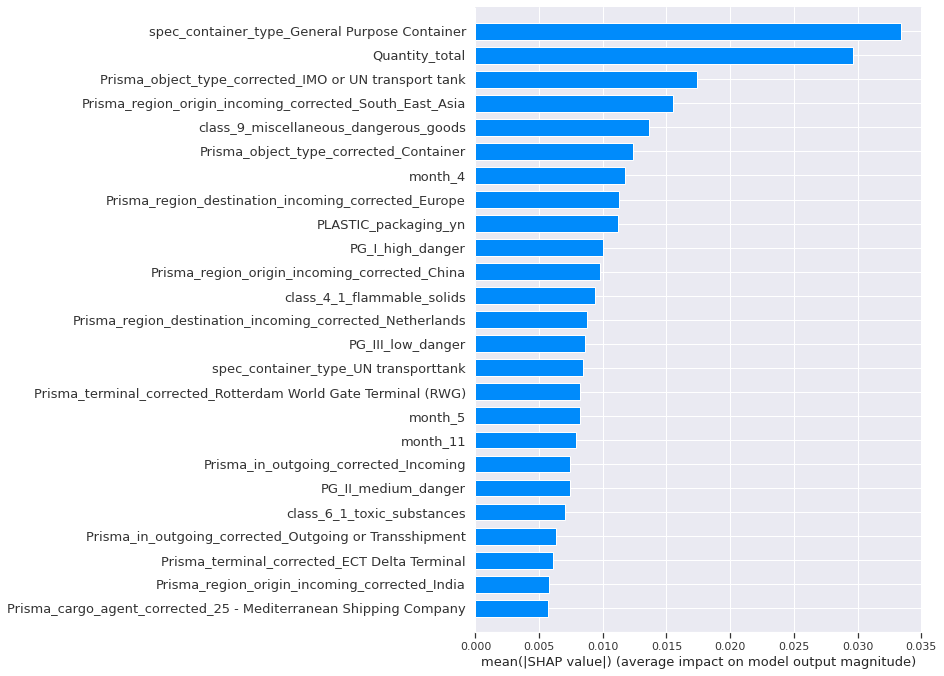

In [40]:
#SHAP
display = 25 
shap.summary_plot(explanation_object.values[1], max_display=display, plot_type='bar', feature_names=X.columns)

# new_plot, ax = plt.subplots()
# shap.summary_plot(explanation_object, max_display=display)

In [1]:
#def a function for this shap_tree comparison
def importance_comparison(X,best_model):
    """
    X: dataframe with data used to fit
    shap_values: dataframe with shap values 
    """
    
    #ranking features based on mean absolute shap
    shap_df = pd.DataFrame(shap_values[1],columns = X.columns)
    shap_mean_s = abs(shap_df).mean(axis=0)
    shap_mean_df = pd.DataFrame(shap_mean_s,columns = ['shap_importance'])
    shap_mean_df = shap_mean_df.sort_values(by='shap_importance',ascending=False)
    shap_mean_df.reset_index(inplace=True)
    shap_mean_df.reset_index(inplace=True)
    shap_mean_df.set_index('index',inplace=True)
    shap_mean_df.columns=['shap_rank','shap_importance']
    
    #ranking features based on value importance
    value_imp = pd.DataFrame({"feature": X.columns, "tree_importance": best_model.feature_importances_})
    value_imp = value_imp.sort_values(['tree_importance'], ascending=False)
    value_imp.set_index('feature',inplace=True)
    value_imp['tree_rank'] = list(range(0,len(value_imp)))
    #joining them
    df = value_imp.join(shap_mean_df)
    
    return df[['tree_rank','shap_rank']]
    
    

In [2]:
importance_comparison(X,best_model)

NameError: name 'X' is not defined

In [172]:
#checking best model score with vanilla stuff (all data,regions, no groupby)

main_fit(X,groupby=None)

{'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000, 1100], 'max_features': [86, 7, 10, 8, 9, 11, 43]}


KeyboardInterrupt: 

### compare SHAP and feature importance with model trained on all data, check performance
#then do the same for :
1. Replace regions with countries
2. Replace countries with GDP,something else
3. GroupKFOLD with 1 variable
4. GroupKfold with 2 variable


## Experiment 1: countries

In [6]:
exp1_df = pd.read_csv('HOLMES_data_2019_all.csv')
df = pd.read_csv('clean_holmes_2019.csv')

### Selecting relevant columns

In [7]:
#just clean it and get origin countries and cargo agent
#700 tons is too much for one container, therefore it is being discarded
exp1_df = exp1_df[exp1_df['Quantity_total']<100000]
exp1_df = exp1_df[exp1_df['Quantity_total']>10]
exp1_df = exp1_df['ORIGINAL_Prisma_incoming_country_origin']
exp1_df.reset_index(inplace=True,drop=True)

In [8]:
#replacing the region with the actual countries
col_to_del = list()
for col in df.columns:
    if 'Prisma_region_origin_incoming' in col:
        col_to_del.append(col)

In [9]:
df.drop(col_to_del,axis=1,inplace=True)

In [10]:
df['country'] = exp1_df

In [11]:
df.country

0       CN
1       IN
2       AR
3       RU
4       RU
5       RU
6       CL
7       CN
8       ID
9       CN
10      IN
11      CN
12      CN
13      BR
14      IN
15      IN
16      CN
17      CN
18      CN
19      IN
20      TH
21      CL
22      BR
23      IN
24      IN
25      IN
26      CN
27      DO
28      TH
29      IN
30      TH
31      IN
32     NaN
33      IN
34      IN
35      EG
36      BR
37      IN
38     NaN
39      IN
40      CN
41      CN
42      HK
43      HK
44      ZA
45      CN
46      CN
47      CN
48      CN
49      CN
50      ZA
51     NaN
52      TR
53      HK
54      IN
55      CN
56      CN
57      CN
58      IL
59      IN
60     NaN
61      CN
62      CN
63      IN
64      IN
65      IL
66      IN
67     NaN
68      IN
69      IN
70      CN
71      CN
72      IN
73      US
74      IN
75      IN
76      CN
77      CN
78      BR
79      ZA
80      KR
81      HK
82      CN
83      IN
84      IN
85      ID
86      CN
87      IN
88      IN
89      IN
90      US

In [17]:
main_fit(df,groupby='country')

{'max_depth': [5, 10, 15, 20], 'n_estimators': [100, 500, 1000, 1100], 'max_features': [87, 7, 10, 8, 9, 11, 44]}
Groupby:  country
 Countries used in training : ['CN' 'AR' 'RU' 'CL' 'ID' 'BR' 'TH' 'DO' nan 'EG' 'HK' 'ZA' 'TR' 'IL' 'US' 'KR' 'NO' 'MX' 'CO' 'JP' 'SA' 'VN'
 'SG' 'UY' 'AE' 'PE' 'MA' 'TW' 'MY' 'VG' 'LB' 'BO' 'GT' 'IS' 'AU' 'PH' 'CR' 'MU' 'BA' 'VE' 'GB']
 Countries used in testing : ['IN']


KeyboardInterrupt: 

In [ ]:
#value importance is useful to understand where the rf makes the most splits

valueImp = pd.DataFrame({"feature": X.columns, "importance": best_model.feature_importances_})
valueImp = valueImp.sort_values(['importance'], ascending=False)
valueImp.set_index('feature',inplace=True)
valueImp[0:25].plot(kind='bar',)

fig = plt.gcf()
fig.set_size_inches(12.5, 9.5)
font = {'weight':'normal',
    'size' : 24}
plt.rc('font', **font)
plt.show()

## Performance on the OOS



In [ ]:
##finding the precision on the OOS
print('Precision on OOS: ',precision_score(y_OOS,y_pred_OOS))
print('Accurracy on OOS: ',accuracy_score(y_OOS,y_pred_OOS))
print('Recall on OOS: ',recall_score(y_OOS,y_pred_OOS))
print('ROC_AUC_score OOS: ',roc_auc_score(y_OOS,y_pred_OOS))

## Dashboard Train Performance

In [ ]:
#just like before, we do the performance check for the dashboard etc.
# (not-nested, but simple) cross validation object
inner_cv = StratifiedKFold(n_splits=10, shuffle=True) 

# RF parameter tuning - 
rf_grid = {
    "max_depth"    : [5,10,15,20] #number of max features to be randomly chosen at each split
  , "n_estimators"  : [100,500,1000,1100] 
  , "max_features" : [len(X.columns),
                      math.trunc(round(math.sqrt(len(X.columns)),0)) - 2, 
                      math.trunc(round(math.sqrt(len(X.columns)),0)) +1 ,
                      math.trunc(round(math.sqrt(len(X.columns)),0))- 1,
                      math.trunc(round(math.sqrt(len(X.columns)),0)),
                      math.trunc(round(math.sqrt(len(X.columns)),0)) +2,
                      round(len(X.columns)/2)
                     ]
}
print(rf_grid)

# RF grid search (combines all possible parameters and gives the parameters for the best cv score)
rf_estimator = GridSearchCV(
    estimator = RandomForestClassifier()
    , param_grid = rf_grid
    , scoring = 'precision'
    , cv = inner_cv
    , n_jobs=-1)



In [ ]:
#takes about 40-60 minutes
#we add the label, predicted score and fold to lists and then save it to a csv.
rs = 42
labels = list()
predictions = list()
fold = list()
i = 0

#stratified folds with manual fold retain
skf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X, y):
     
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #fit the grid and retain the best model
    rf_estimator.fit(X_train,y_train)
    best_model = rf_estimator.best_estimator_
    
    #use the best model to get only predicted class 1 scores
    probs = rf_estimator.predict_proba(X_test)[:,1]
    
    #retain ground truth labels,predictions and fold numbers
    labels.append(y_test.tolist())
    predictions.append(probs)
    fold.append([i]*len(probs))
    
    #show progress
    print(i)
    i=i+1

In [ ]:
#flattening
labels_flat   = [val for sublist in labels for val in sublist]
predictions_flat   = [val for sublist in predictions for val in sublist]
fold_flat   = [val for sublist in fold for val in sublist]

In [ ]:
dev_dict = {'labels':labels_flat,
           'predictions':predictions_flat,
           'fold':fold_flat}
dev_set = pd.DataFrame.from_dict(dev_dict)


In [ ]:
dev_set.to_csv('dev_set_GS_zeevaart_real.csv',index=False)
#to be used in the dashboard to generate plots and stuff